# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cleaning import clean_data,plot_attribute_distribution

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

# Attributes:
AGER_TYP - Ager Typology  

AKT_DAT_KL - Act date KL

ALTER_HH - Hamburg Germany only (this is a huge city in the north of Germany where Bertelsmann/Arvato is located),

ALTER_KIND1 - age of child no. 1

ALTER_KIND2 - age of child no. 2

ALTER_KIND3 - age of child no. 3

ALTER_KIND4 - age of child no. 4

ALTERKATEGORIE_FEIN - age categories ('fein' in this case I guess means a more specific classification)

ANZ_KINDER - no. of children

ANZ_STATISTISCHE_HAUSHALTE - in Germany a census data is given about statistical households, here its number is counted

ARBEIT - work

D19_KONSUMTYP_MAX - what kind of consumption type you are

D19_LETZTER_KAUF_BRANCHE - the last date you bought something and in what category/segment

D19_VERSI_DATUM - insurance date

D19_VERSI_OFFLINE_DATUM - insurance date offline

D19_VERSI_ONLINE_DATUM - insurance date online

D19_VERSI_ONLINE_QUOTE_12 - insurance online in the last 12 month

DSL_FLAG - what kind of DSL are you using/ are you in (unfortunately some German regions are still IT medieval, not having a stable internet)

EINGEFUEGT_AM - inserted on

EINGEZOGEN_HH_JAHR - moved to household in year <yyyy>
    
FIRMENDICHTE - company density

KOMBIALTER - 'Kombi' means combination and 'Alter' is age

STRUKTURTYP - what kind of structural type you are

UMFELD_ALT - surrounding/neighbourhood is old

UMFELD_JUNG - surrounding/neighbourhood is young

VERDICHTUNGSRAUM - I guess they mean the urban agglomeration

VERS_TYP - what kind of insurance type you are

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
customers.columnsumns

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VK_ZG11', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=369)

In [3]:
pd.set_option('display.max_columns',None)

In [4]:
pd.set_option('display.max_rows',None)

In [6]:
# Shape and head of general data
print("General population shape {}.".format(azdias.shape))
azdias.head()

General population shape (891221, 366).


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [7]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

In [8]:
# Shape and head of customers data
print("Customers shape {}.".format(customers.shape))
customers.head()

Customers shape (191652, 369).


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [9]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

In [3]:
#droping columns that have different colum names form Customer dataset 
customers=customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 
       'ALTERSKATEGORIE_GROB','PRODUCT_GROUP'],axis=1)

In [11]:
# Concat Two columns for plotting
azdias['dataset'] = 'Azdias'
customers['dataset'] = 'Customers'
combine_df = pd.concat([azdias, customers])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


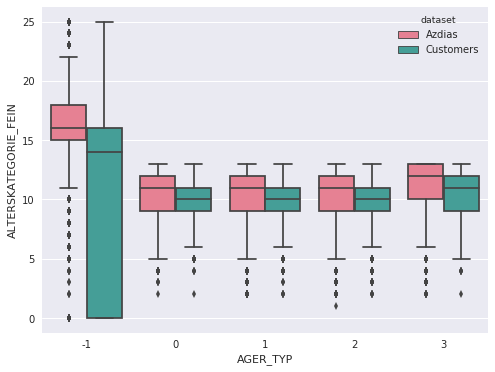

In [16]:
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
sns.boxplot(x="AGER_TYP", y="ALTERSKATEGORIE_FEIN",dodge=True,hue="dataset",data=combine_df,palette="husl");

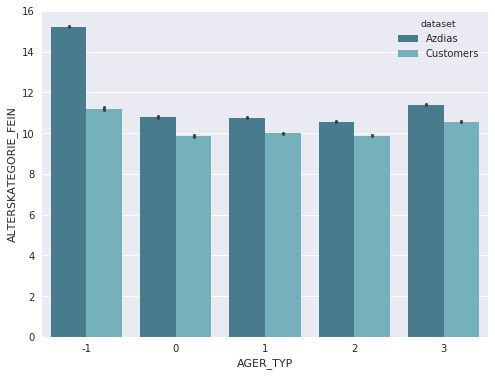

In [21]:
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
sns.barplot(x="AGER_TYP", y="ALTERSKATEGORIE_FEIN", hue="dataset",data=combine_df,palette='GnBu_d')

Let's first randomly choose some columns to see the distribution of azdias and customers dataset.

In [18]:
def plot_comparison(column):
    sns.set(style="darkgrid")
    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
    sns.countplot(x = column, data=azdias, ax=ax1, palette="husl")
    ax1.set_xlabel('Value')
    ax1.set_title('Distribution of feature in AZDIAS dataset')
    sns.countplot(x = column, data=customers, ax=ax2, palette="husl")
    ax2.set_xlabel('Value')
    ax2.set_title('Distribution of feature in CUSTOMERS dataset')
    fig.tight_layout()
    plt.show()

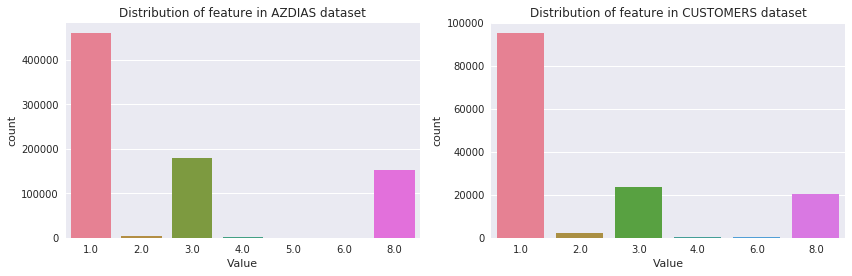

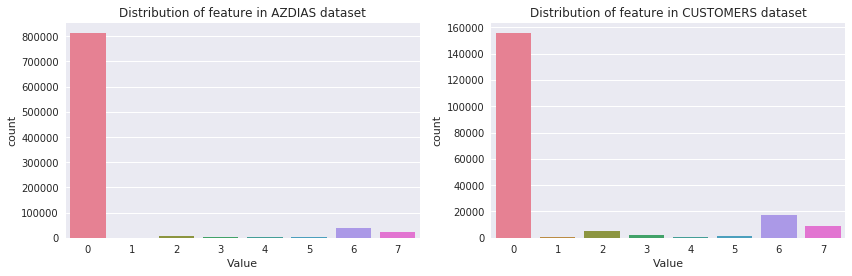

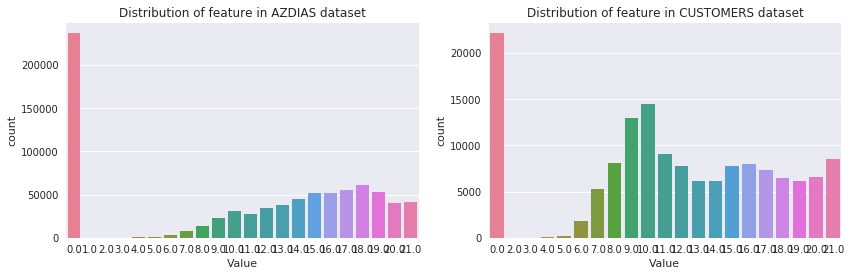

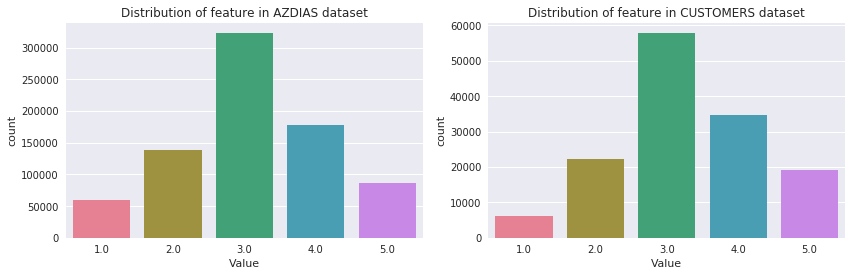

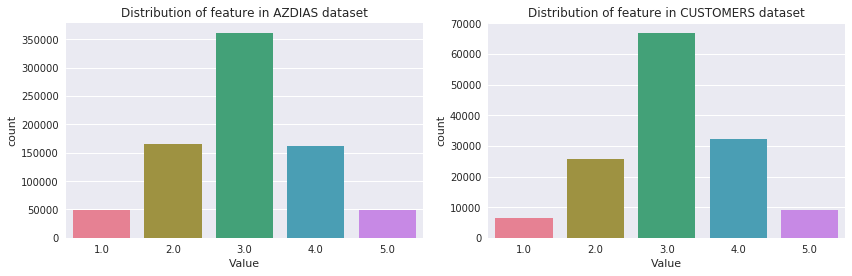

In [20]:
import random
for i in range(5):
    plot_comparison(azdias.columns[random.randint(0, azdias.shape[1])])

In [12]:
col_nul_percent=azdias.isnull().sum()/azdias.shape[0]
col_nul_percent

LNR                            0.000000
AGER_TYP                       0.000000
AKT_DAT_KL                     0.082470
ALTER_HH                       0.082470
ALTER_KIND1                    0.909048
ALTER_KIND2                    0.966900
ALTER_KIND3                    0.993077
ALTER_KIND4                    0.998648
ALTERSKATEGORIE_FEIN           0.295041
ANZ_HAUSHALTE_AKTIV            0.104517
ANZ_HH_TITEL                   0.108848
ANZ_KINDER                     0.082470
ANZ_PERSONEN                   0.082470
ANZ_STATISTISCHE_HAUSHALTE     0.104517
ANZ_TITEL                      0.082470
ARBEIT                         0.109082
BALLRAUM                       0.105182
CAMEO_DEU_2015                 0.111060
CAMEO_DEUG_2015                0.111060
CAMEO_INTL_2015                0.111060
CJT_GESAMTTYP                  0.005446
CJT_KATALOGNUTZER              0.005446
CJT_TYP_1                      0.005446
CJT_TYP_2                      0.005446
CJT_TYP_3                      0.005446


In [13]:
sorted_missing_info=col_nul_percent.sort_values(ascending=False)

Distribution of missing values in AZDIAS dataset


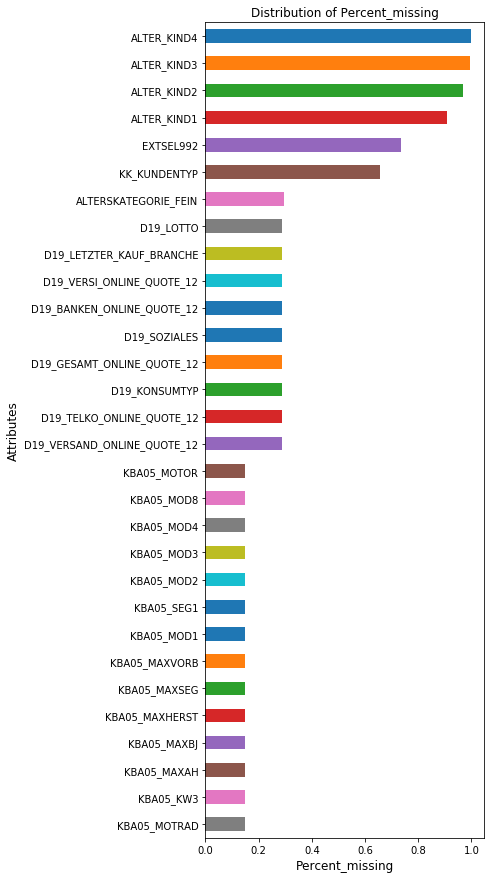

In [14]:
#plot barh plot of final missing values in Azdias
print("Distribution of missing values in AZDIAS dataset")
plot_attribute_distribution(sorted_missing_info, "Attributes", "Percent_missing", 30)

## Data Preprocessing

#### Start cleaning the azdias dataset

In [4]:
cleaned_azdias = clean_data(azdias)

Drop columns with more than 30% of missing values and Droping unnecessary columns
column EINGEFUEGT_AM and D19_LETZTER_KAUF_BRANCHE have too many different items
droping ID column from dataset
missing before


AttributeError: 'NoneType' object has no attribute 'isnull'

In [ ]:
# performing without clean_data function....... on Azdias dataset

In [3]:
cleaned_azdias= azdias.copy()

In [4]:
cleaned_azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
#droping columns that have more than 30% of Nan values from azdias dataset and Droping unnecessary columns
# column EINGEFUEGT_AM and D19_LETZTER_KAUF_BRANCHE have too many different items
# droping ID column from dataset

cleaned_azdias.drop(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4','EXTSEL992','KK_KUNDENTYP',
                     'RT_KEIN_ANREIZ','CJT_TYP_6','D19_VERSI_ONLINE_QUOTE_12','CJT_TYP_2','EINGEZOGENAM_HH_JAHR',
                     'D19_LOTTO','CJT_KATALOGNUTZER','VK_ZG11','UMFELD_ALT','RT_SCHNAEPPCHEN','AGER_TYP', 'ALTER_HH', 
                     'D19_BANKEN_ONLINE_QUOTE_12','D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP','D19_VERSAND_ONLINE_QUOTE_12',
                     'GEBURTSJAHR','KBA05_BAUMAX','TITEL_KZ','D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',                                        'D19_BANKEN_ONLINE_DATUM', 
                     'D19_GESAMT_DATUM',  'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM','D19_TELKO_DATUM', 
                     'D19_TELKO_OFFLINE_DATUM','D19_TELKO_ONLINE_DATUM',  'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 
                     'D19_VERSAND_ONLINE_DATUM', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM','D19_VERSI_ONLINE_DATUM',
                     'CAMEO_DEU_2015',  'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN',  'ANREDE_KZ', 'GREEN_AVANTGARDE',  'SOHO_KZ',
                     'VERS_TYP',  'LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN','EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE',
                     'LNR'],axis=1,inplace=True)

In [6]:
cleaned_azdias.shape

(891221, 314)

In [7]:
cleaned_azdias.select_dtypes(include=['object']).columns

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'OST_WEST_KZ'], dtype='object')

In [8]:
cleaned_azdias['OST_WEST_KZ'].value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [9]:
cleaned_azdias.shape

(891221, 314)

In [10]:
#clean azdias dataset
cleaned_azdias['n_missing']=cleaned_azdias.isnull().sum(axis=1)

In [11]:
cleaned_azdias=cleaned_azdias[cleaned_azdias['n_missing']<=25].drop("n_missing",axis=1)

In [12]:
cleaned_azdias.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB
1,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,0.0,0.0,4.0,8.0,11.0,3.0,9.0,4.0,5,1
2,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,1.0,0.0,2.0,9.0,9.0,3.0,9.0,2.0,5,3
3,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,1.0,0.0,7.0,10.0,NaN,9.0,7.0,3,4
4,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,1.0,0.0,2.0,3.0,5.0,2.0,9.0,3.0,4,3
5,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,0.0,0.0,2.0,10.0,7.0,6.0,9.0,7.0,4,1


In [13]:
#O -> 0, W -> 1
print("Reencode OST_WEST_KZ attribute")
cleaned_azdias['OST_WEST_KZ'].replace(['O','W'], [0, 1], inplace=True)

Reencode OST_WEST_KZ attribute


In [14]:
#change object type of CAMEO_DEUG_2015 to numeric type

#droping the rows that contains string X  
cleaned_azdias=cleaned_azdias[~cleaned_azdias['CAMEO_DEUG_2015'].isin(['X'])]
cleaned_azdias["CAMEO_DEUG_2015"] = pd.to_numeric(cleaned_azdias["CAMEO_DEUG_2015"])

In [15]:
'''
    Engineer two new attributes from PRAEGENDE_JUGENDJAHRE: MOVEMENT and GENERATION_DECADE
    PRAEGENDE_JUGENDJAHRE initial encoding
    Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
    - -1: unknown
    -  0: unknown
    -  1: 40s - war years (Mainstream, E+W)
    -  2: 40s - reconstruction years (Avantgarde, E+W)
    -  3: 50s - economic miracle (Mainstream, E+W)
    -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
    -  5: 60s - economic miracle (Mainstream, E+W)
    -  6: 60s - generation 68 / student protestors (Avantgarde, W)
    -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
    -  8: 70s - family orientation (Mainstream, E+W)
    -  9: 70s - peace movement (Avantgarde, E+W)
    - 10: 80s - Generation Golf (Mainstream, W)
    - 11: 80s - ecological awareness (Avantgarde, W)
    - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
    - 13: 80s - Swords into ploughshares (Avantgarde, E)
    - 14: 90s - digital media kids (Mainstream, E+W)
    - 15: 90s - ecological awareness (Avantgarde, E+W)
    
Final encooding:
    
    "MOVEMENT": 
    - 1: Mainstream
    - 2: Avantgarde
    “GENERATION_DECADE”:
    - 4: 40s
    - 5: 50s
    - 6: 60s
    - 7: 70s
    - 8: 80s
    - 9: 90s
'''    
    

#create new binary attribute MOVEMENT with values Avantgarde (0) vs Mainstream (1)
cleaned_azdias['MOVEMENT'] = cleaned_azdias['PRAEGENDE_JUGENDJAHRE']
cleaned_azdias['MOVEMENT'].replace([-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
                           [np.nan,np.nan,1,2,1,2,1,2,2,1,2,1,2,1,2,1,2], inplace=True)

#create new ordinal attribute GENERATION_DECADE with values 40s, 50s 60s ... encoded as 4, 5, 6 ...
cleaned_azdias['GENERATION_DECADE'] = cleaned_azdias['PRAEGENDE_JUGENDJAHRE']
cleaned_azdias['GENERATION_DECADE'].replace([-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
                                    [np.nan,np.nan,4,4,5,5,6,6,6,7,7,8,8,8,8,9,9], inplace=True) 

#delete 'PRAEGENDE_JUGENDJAHRE'
cleaned_azdias = cleaned_azdias.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)


In [16]:
'''
    Engineer RURAL_NEIGHBORHOOD from WOHNLAGE attribute
    "WOHNLAGE" feature could be divided into “RURAL_NEIGHBORHOOD” and “QUALITY_NEIGHBORHOOD”.
    However, there are 24% of rural data that will have missing values in "QUALITY_NEIGHBORHOOD”
    feature, therefore only binary "RURAL_NEIGHBORHOOD" feature was created inplace of "WOHNLAGE"
    Initial encoding of WOHNLAGE:
    
    Neighborhood quality (or rural flag)
    - -1: unknown
    -  0: no score calculated
    -  1: very good neighborhood
    -  2: good neighborhood
    -  3: average neighborhood
    -  4: poor neighborhood
    -  5: very poor neighborhood
    -  7: rural neighborhood
    -  8: new building in rural neighborhood
    
    Final encooding:
    
    "RURAL_NEIGBORHOOD"
    - 0: Not Rural
    - 1: Rural
'''

#create new binary attribute RURAL_NEIGHBORHOOD with values Rural (1) vs NotRural(0)
cleaned_azdias['RURAL_NEIGHBORHOOD'] = cleaned_azdias['WOHNLAGE']
cleaned_azdias['RURAL_NEIGHBORHOOD'].replace([-1,0,1,2,3,4,5,7,8], [np.nan,np.nan,0,0,0,0,0,1,1], inplace=True)

#delete 'WOHNLAGE'
cleaned_azdias = cleaned_azdias.drop(['WOHNLAGE'], axis=1)

In [17]:
 '''
    Engineer PLZ8_BAUMAX_BUSINESS and PLZ8_BAUMAX_FAMILY attributes from PLZ8_BAUMAX attribute
   
    PLZ8_BAUMAX initial encoding:
    Most common building type within the PLZ8 region
    - -1: unknown
    -  0: unknown
    -  1: mainly 1-2 family homes
    -  2: mainly 3-5 family homes
    -  3: mainly 6-10 family homes
    -  4: mainly 10+ family homes
    -  5: mainly business buildings
    
    Final encoding:
    “PLZ8_BAUMAX_BUSINESS”
    - 0: Not Business
    - 1: Business
    “PLZ8_BAUMAX_FAMILY”
    - 0: 0 families
    - 1: mainly 1-2 family homes
    - 2: mainly 3-5 family homes
    - 3: mainly 6-10 family homes
    - 4: mainly 10+ family homes
'''
    
#create new binary attribute PLZ8_BAUMAX_BUSINESS with values Business (1) vs Not Business(0)
cleaned_azdias['PLZ8_BAUMAX_BUSINESS'] = cleaned_azdias['PLZ8_BAUMAX']
cleaned_azdias['PLZ8_BAUMAX_BUSINESS'].replace([1,2,3,4,5], [0,0,0,0,1], inplace=True) 

#create new ordinal attribute PLZ8_BAUMAX_FAMILY with from 1 to 4 encoded as in data dictionary
cleaned_azdias['PLZ8_BAUMAX_FAMILY'] = cleaned_azdias['PLZ8_BAUMAX']
cleaned_azdias['PLZ8_BAUMAX_FAMILY'].replace([5], [0], inplace=True) 

#delete 'PLZ8_BAUMAX'
cleaned_azdias = cleaned_azdias.drop(['PLZ8_BAUMAX'], axis=1)        

In [ ]:
#check below code

In [18]:
kba_cols = cleaned_azdias.columns[cleaned_azdias.columns.str.startswith('KBA')]

In [19]:
kba_cols

Index(['KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4',
       'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_AUTOQUOT',
       ...
       'KBA13_SITZE_4', 'KBA13_SITZE_5', 'KBA13_SITZE_6', 'KBA13_TOYOTA',
       'KBA13_VORB_0', 'KBA13_VORB_1', 'KBA13_VORB_1_2', 'KBA13_VORB_2',
       'KBA13_VORB_3', 'KBA13_VW'],
      dtype='object', length=180)

In [20]:
cleaned_azdias.drop(list(kba_cols), axis='columns', inplace=True)

In [21]:
cleaned_azdias.shape

(751042, 136)

In [23]:
cleaned_azdias.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_DISTANZ,W_KEIT_KIND_HH,WOHNDAUER_2008,ZABEOTYP,ALTERSKATEGORIE_GROB,MOVEMENT,GENERATION_DECADE,RURAL_NEIGHBORHOOD,PLZ8_BAUMAX_BUSINESS,PLZ8_BAUMAX_FAMILY
1,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,11.0,3.0,9.0,5,1,1.0,9.0,0.0,0.0,1.0
2,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,9.0,3.0,9.0,5,3,2.0,9.0,0.0,0.0,1.0
3,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,10.0,NaN,9.0,3,4,1.0,7.0,1.0,0.0,1.0
4,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,5.0,2.0,9.0,4,3,1.0,7.0,0.0,0.0,2.0
5,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,7.0,6.0,9.0,4,1,1.0,5.0,1.0,0.0,1.0


In [24]:
# Drop the ID column and do Fit_transform to all the data
cleaned_azdias.fillna(0, inplace=True)

In [26]:
cleaned_azdias.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_DISTANZ,W_KEIT_KIND_HH,WOHNDAUER_2008,ZABEOTYP,ALTERSKATEGORIE_GROB,MOVEMENT,GENERATION_DECADE,RURAL_NEIGHBORHOOD,PLZ8_BAUMAX_BUSINESS,PLZ8_BAUMAX_FAMILY
1,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,11.0,3.0,9.0,5,1,1.0,9.0,0.0,0.0,1.0
2,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,9.0,3.0,9.0,5,3,2.0,9.0,0.0,0.0,1.0
3,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,10.0,0.0,9.0,3,4,1.0,7.0,1.0,0.0,1.0
4,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,5.0,2.0,9.0,4,3,1.0,7.0,0.0,0.0,2.0
5,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,7.0,6.0,9.0,4,1,1.0,5.0,1.0,0.0,1.0


In [32]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [33]:
cleaned_azdias= scaler.fit_transform(cleaned_azdias)

In [35]:
cleaned_azdias

array([[ 1.24925253,  1.44445868,  0.15885081, ..., -0.54655491,
        -0.38307709, -0.30721653],
       [ 1.24925253,  0.8956385 ,  0.09501729, ..., -0.54655491,
        -0.38307709, -0.30721653],
       [-0.94257571,  0.34681833, -0.47948435, ...,  1.82964232,
        -0.38307709, -0.30721653],
       ..., 
       [-0.94257571,  0.8956385 , -0.35181732, ...,  1.82964232,
        -0.38307709, -0.30721653],
       [ 1.24925253,  1.30725363, -0.09648326, ..., -0.54655491,
         2.61044061, -1.27709656],
       [-0.94257571, -1.43684724,  0.09501729, ..., -0.54655491,
        -0.38307709, -0.30721653]])

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [36]:
from sklearn.decomposition import PCA
# Apply PCA to the data.

In [37]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

CPU times: user 58.3 s, sys: 4.3 s, total: 1min 2s
Wall time: 1min 21s


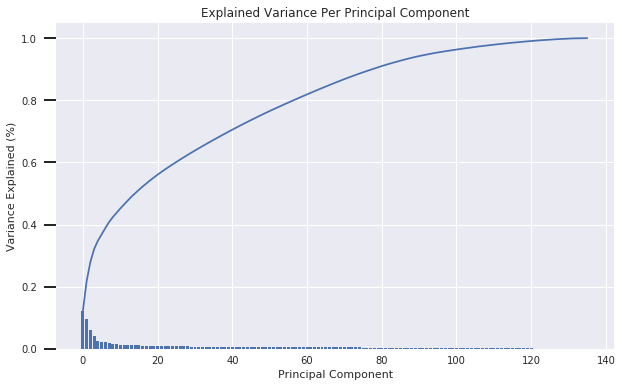

In [42]:
%%time
pca = PCA()
azdias_pca = pca.fit_transform(cleaned_azdias)
scree_plot(pca)

In [43]:
explained_var_ratio = sum(pca.explained_variance_ratio_)
print("Explained variance ratio:", explained_var_ratio.round(2)*100)

Explained variance ratio: 100.0


In [44]:
print("Azdias shape {}.".format(azdias_pca.shape))


Azdias shape (751042, 136).


CPU times: user 25.1 s, sys: 4.29 s, total: 29.4 s
Wall time: 33.5 s


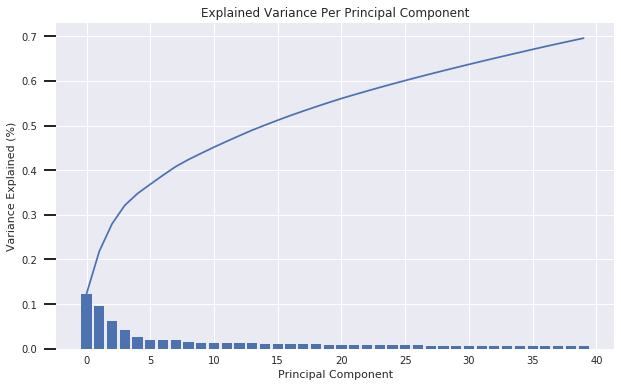

In [45]:
%%time
pca = PCA(40)
df_pca = pca.fit_transform(cleaned_azdias)
scree_plot(pca)

In [47]:
explained_var_ratio = sum(pca.explained_variance_ratio_)
print("Explained variance ratio:", explained_var_ratio.round(2)*100)

Explained variance ratio: 70.0


In [48]:
print("Azdias shape {}.".format(df_pca.shape))

Azdias shape (751042, 40).


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')